In [11]:
from ultralytics import YOLO

from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import supervision as sv

In [18]:
import ssl

print(ssl.get_default_verify_paths())

DefaultVerifyPaths(cafile='/etc/ssl/certs/ca-certificates.crt', capath='/usr/lib/ssl/certs', openssl_cafile_env='SSL_CERT_FILE', openssl_cafile='/usr/lib/ssl/cert.pem', openssl_capath_env='SSL_CERT_DIR', openssl_capath='/usr/lib/ssl/certs')


In [ ]:
import ssl

print(ssl.get_default_verify_paths())


import requests

response = requests.get("https://api.github.com")
print(response.status_code)
print(response.json())

SSLError: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)')))

In [7]:
# detector = YOLO("/home/ap/Projects/MLBox/assets/runs/2024-12-17-yolov8seg-1024/train/weights/best.pt")
detector = YOLO(
    "/mnt/c/My\ storage/Python\ projects/MLBox/scripts/train/2024-12-17-yolov8seg-1024/train/weights/best.pt"
)

# classifier = YOLO("/home/ap/Projects/MLBox/assets/runs/2024-12-18-yolov8s-cls/train2/weights/best.pt")

SSLError: HTTPSConnectionPool(host='api.github.com', port=443): Max retries exceeded with url: /repos/ultralytics/assets/releases/tags/v8.3.0 (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)')))

In [3]:
image = Image.open(
    "/home/ap/Projects/MLBox/tmp/2024-12-20-test-models/WhatsApp Image 2024-12-20 at 16.41.46.jpeg"
).convert("RGB")

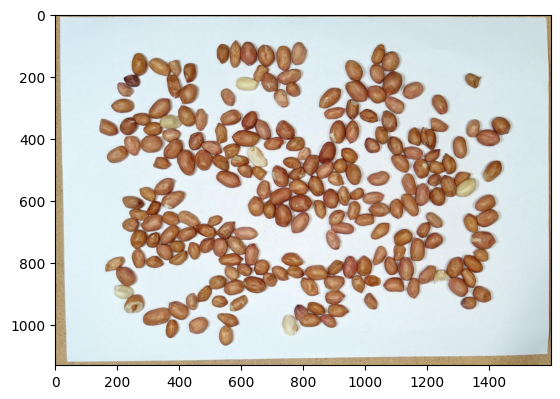

In [4]:
plt.imshow(image)
plt.show()

In [52]:
detections = detector.predict(np.array(image), imgsz=1024, conf=0.8)


0: 736x1024 223 peanuts, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 9.1ms postprocess per image at shape (1, 3, 736, 1024)


In [53]:
detections = sv.Detections.from_ultralytics(detections[0])

In [54]:
detections.mask.shape

(223, 1131, 1600)

In [55]:
crops = []
for i in tqdm(range(len(detections))):
    xmin, ymin, xmax, ymax = detections.xyxy[i]
    crop = image.crop((xmin, ymin, xmax, ymax))
    crops.append(crop)

classifications = classifier.predict(crops, imgsz=128, conf=0.66, verbose=False)
indices_1_2 = np.where(np.array([c.probs.top1 in [1, 2] for c in classifications]))[0]

print(f"Found {len(indices_1_2)} crops with top1 in [1, 2]")

100%|██████████| 223/223 [00:00<00:00, 77479.27it/s]

Found 10 crops with top1 in [1, 2]


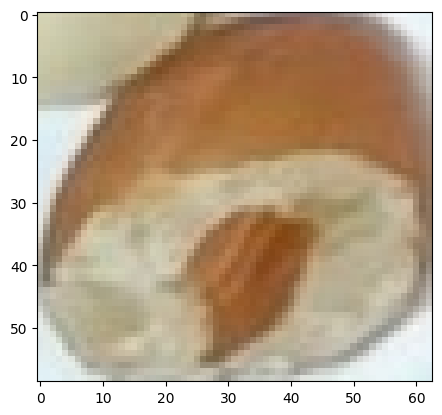

In [66]:
# det_i = 7
det_i = indices_1_2[0]

xmin, ymin, xmax, ymax = map(int, detections.xyxy[det_i])
mask = detections.mask[det_i]

crop = image.crop((xmin, ymin, xmax, ymax))
mask = mask[ymin:ymax, xmin:xmax]

plt.imshow(crop)
plt.show()

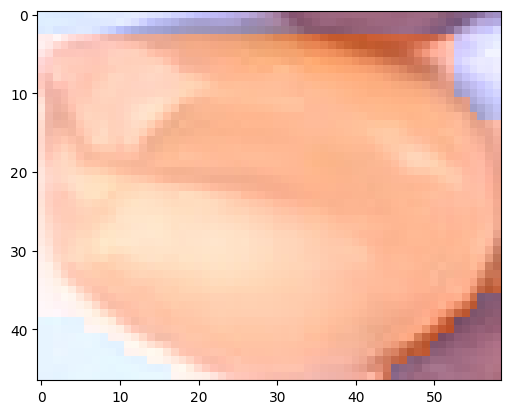

In [33]:
mask_resized = cv2.resize(mask.astype(np.uint8), (crop.width, crop.height))
mask_colored = cv2.applyColorMap(mask_resized * 255, cv2.COLORMAP_JET)
mask_colored = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB)

crop_np = np.array(crop)
overlay = cv2.addWeighted(crop_np, 1, mask_colored, 0.5, 0)

plt.imshow(overlay)
plt.show()

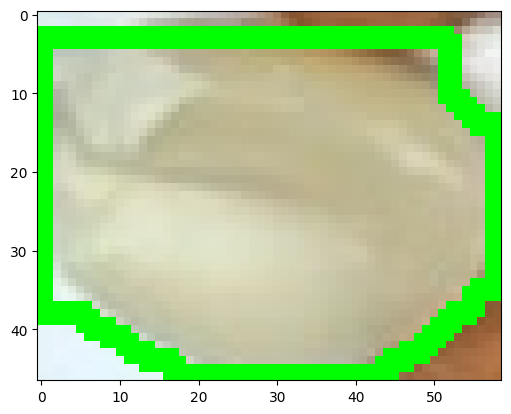

In [ ]:
# Convert boolean mask to uint8
mask_uint8 = mask.astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the image
contour_image = cv2.drawContours(np.array(crop), contours[0], -1, (0, 255, 0), 2)

# Display the image with contours
plt.imshow(contour_image)
plt.show()

In [1]:
# Convert the contour to a format suitable for cv2.fitEllipse
contour_points = contours[0].reshape(-1, 2)

# Fit an ellipse to the contour points
ellipse = cv2.fitEllipse(contour_points)

# Calculate the scaling factor to shrink the ellipse
scale_factor = 1  # Adjust this factor as needed

# Scale down the ellipse dimensions
center, axes, angle = ellipsPe
scaled_axes = (axes[0] * scale_factor, axes[1] * scale_factor)
scaled_ellipse = (center, scaled_axes, angle)

# Draw the scaled ellipse on the image
ellipse_image = np.array(crop).copy()
cv2.ellipse(ellipse_image, scaled_ellipse, (0, 255, 60), 1)

# Display the image with the fitted ellipse
plt.imshow(ellipse_image)
plt.show()

NameError: name 'contours' is not defined

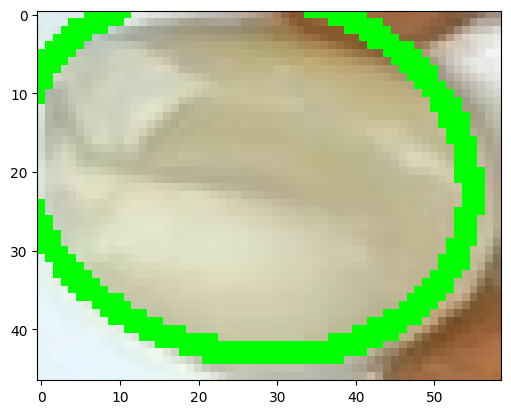

In [36]:
# Generate points for the new contour from the ellipse
ellipse_contour = cv2.ellipse2Poly(
    (int(center[0]), int(center[1])),
    (int(scaled_axes[0] / 2), int(scaled_axes[1] / 2)),
    int(angle),
    0,
    360,
    1,
)

# Replace the original contour with the new ellipse contour
contours = (ellipse_contour,)

# Display the new contour on the image
new_contour_image = cv2.drawContours(np.array(crop), contours, -1, (0, 255, 0), 2)
plt.imshow(new_contour_image)
plt.show()

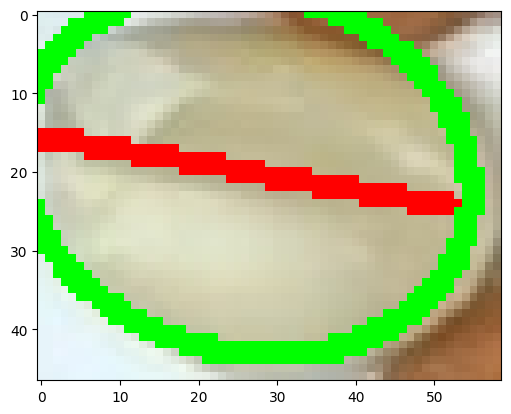

Largest chord length: 58.855755878248644


In [37]:
# Find the convex hull of the contour
hull = cv2.convexHull(contours[0])

# Calculate the maximum distance between any two points on the hull
max_distance = 0
for i in range(len(hull)):
    for j in range(i + 1, len(hull)):
        distance = np.linalg.norm(hull[i] - hull[j])
        if distance > max_distance:
            max_distance = distance
            point1 = tuple(hull[i][0])
            point2 = tuple(hull[j][0])

# Draw the largest chord on the image
chord_image = np.array(crop).copy()
cv2.line(chord_image, point1, point2, (255, 0, 0), 2)

# Draw the original contour on the image
cv2.drawContours(chord_image, contours, 0, (0, 255, 0), 2)

# Display the image with the largest chord
plt.imshow(chord_image)
plt.show()

# Print the largest chord length
print(f"Largest chord length: {max_distance}")

In [38]:
# Calculate the midpoint of the largest chord
midpoint = ((point1[0] + point2[0]) // 2, (point1[1] + point2[1]) // 2)

# Calculate the slope of the largest chord
if point2[0] - point1[0] != 0:
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
else:
    slope = float("inf")

# Calculate the slope of the orthogonal chord (negative reciprocal of the original slope)
if slope != 0:
    ortho_slope = -1 / slope
else:
    ortho_slope = float("inf")


# Define a function to find the intersection of the orthogonal chord with the hull
def find_intersection(midpoint, ortho_slope, hull):
    intersections = []
    for i in range(len(hull)):
        x1, y1 = hull[i][0]
        x2, y2 = hull[(i + 1) % len(hull)][0]
        if x2 - x1 != 0:
            edge_slope = (y2 - y1) / (x2 - x1)
        else:
            edge_slope = float("inf")

        if ortho_slope != edge_slope:
            if ortho_slope != float("inf") and edge_slope != float("inf"):
                x_intersect = (
                    edge_slope * x1 - y1 - ortho_slope * midpoint[0] + midpoint[1]
                ) / (edge_slope - ortho_slope)
                y_intersect = ortho_slope * (x_intersect - midpoint[0]) + midpoint[1]
            elif ortho_slope == float("inf"):
                x_intersect = midpoint[0]
                y_intersect = edge_slope * (x_intersect - x1) + y1
            else:
                x_intersect = x1
                y_intersect = ortho_slope * (x_intersect - midpoint[0]) + midpoint[1]

            if min(x1, x2) <= x_intersect <= max(x1, x2) and min(
                y1, y2
            ) <= y_intersect <= max(y1, y2):
                intersections.append((int(x_intersect), int(y_intersect)))

    return intersections


# Find the intersections of the orthogonal chord with the hull
intersections = find_intersection(midpoint, ortho_slope, hull)

# Draw the orthogonal chord on the image
if len(intersections) == 2:
    ortho_chord_image = np.array(crop).copy()
    cv2.line(ortho_chord_image, intersections[0], intersections[1], (0, 0, 255), 2)

    # Draw the original contour on the image
    cv2.drawContours(ortho_chord_image, contours, 0, (0, 255, 0), 2)

    # Display the image with the orthogonal chord
    plt.imshow(ortho_chord_image)
    plt.show()
else:
    print("Could not find two intersections for the orthogonal chord.")

Could not find two intersections for the orthogonal chord.


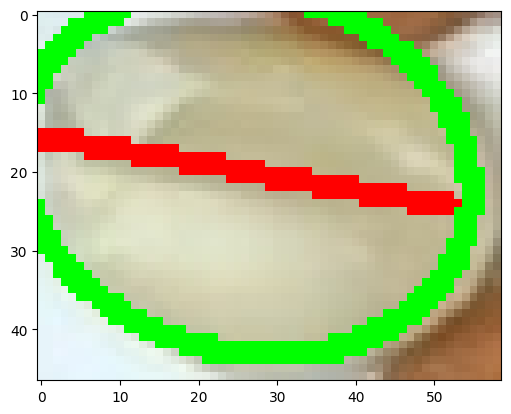

Largest chord start point: (-3, 15), end point: (55, 25)
Could not find two intersections for the orthogonal chord.
Largest chord length: 58.855755878248644
Orthogonal chord length: Not available
Estimated area of the contour: Not available


In [39]:
# Draw the largest chord on the image
cv2.line(crop_np, point1, point2, (255, 0, 0), 2)

# Draw the orthogonal chord on the image
if len(intersections) == 2:
    cv2.line(crop_np, intersections[0], intersections[1], (0, 0, 255), 2)

# Draw the contour on the image
cv2.drawContours(crop_np, contours, -1, (0, 255, 0), 2)

# Display the image with the contour and chords
plt.imshow(crop_np)
plt.show()

# Print the coordinates of the chords
print(f"Largest chord start point: {point1}, end point: {point2}")
if len(intersections) == 2:
    print(
        f"Orthogonal chord start point: {intersections[0]}, end point: {intersections[1]}"
    )
else:
    print("Could not find two intersections for the orthogonal chord.")

# Print the length of each chord
print(f"Largest chord length: {max_distance}")
if len(intersections) == 2:
    ortho_chord_length = np.linalg.norm(
        np.array(intersections[0]) - np.array(intersections[1])
    )
    print(f"Orthogonal chord length: {ortho_chord_length}")
else:
    ortho_chord_length = 0
    print("Orthogonal chord length: Not available")

# Estimate the final area of the contour using the chords' parameters
if ortho_chord_length > 0:
    estimated_area = (max_distance * ortho_chord_length) / 2
    print(f"Estimated area of the contour: {estimated_area}")
else:
    print("Estimated area of the contour: Not available")